<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-2">Data pre-processing</a></span></li><li><span><a href="#HistGradientBoostingClassifier" data-toc-modified-id="HistGradientBoostingClassifier-3">HistGradientBoostingClassifier</a></span></li><li><span><a href="#Class-weights" data-toc-modified-id="Class-weights-4">Class weights</a></span></li><li><span><a href="#Initial-Classifiers" data-toc-modified-id="Initial-Classifiers-5">Initial Classifiers</a></span></li><li><span><a href="#Important-features" data-toc-modified-id="Important-features-6">Important features</a></span></li><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-7">Hyperparameter tuning</a></span></li><li><span><a href="#Including-the-V***-columns" data-toc-modified-id="Including-the-V***-columns-8">Including the V*** columns</a></span><ul class="toc-item"><li><span><a href="#Only-features-deemed-important-by-RF-model-interpretation-with-V***-features" data-toc-modified-id="Only-features-deemed-important-by-RF-model-interpretation-with-V***-features-8.1">Only features deemed important by RF model interpretation with V*** features</a></span></li><li><span><a href="#Only-features-deemed-important-by-RF-model-interpretation" data-toc-modified-id="Only-features-deemed-important-by-RF-model-interpretation-8.2">Only features deemed important by RF model interpretation</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-8.3">XGBoost</a></span></li></ul></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [35]:
from fastai.tabular.all      import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer
from sklearn.experimental    import enable_hist_gradient_boosting 
from sklearn.ensemble        import HistGradientBoostingClassifier
from utils                   import (fit, plot_confusion_matrix, 
                                     metrics, plot_roc_prc)



path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
Path.BASE_PATH = path
pd.options.display.max_rows = 200
pd.options.display.max_columns = 125

# Data pre-processing

In [3]:
# Tabular object created and saved on the 02_ notebook
to = (path/'to_ss.pkl').load()

In [3]:
to["card1"].dtype

dtype('int16')

In [4]:
cats = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38']

for cat in cats:
    to[cat] = to[cat].astype('category')

In [5]:
to["card1"].dtype

CategoricalDtype(categories=[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
                  ...
                  5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655],
                 ordered=False)

In [4]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [5]:
xs.shape, valid_xs.shape, valid_y.sum(), valid_y.mean()

((48491, 122), (10563, 122), 359, 0.03398655684937991)

# HistGradientBoostingClassifier

In [112]:
'Previously, leaf-wise growth was an exclusive feature of lightGBM, but xgboost has since implemented this growth strategy (this change has not been reflected in the lightGBM docs, but has been acknowledged in a blog post). This strategy is only available for the histogram-based method (which I will explain below), so in order to use it, users will have to set the tree_method parameter to hist and the grow_policy parameter to lossguide.'

'Previously, leaf-wise growth was an exclusive feature of lightGBM, but xgboost has since implemented this growth strategy (this change has not been reflected in the lightGBM docs, but has been acknowledged in a blog post). This strategy is only available for the histogram-based method (which I will explain below), so in order to use it, users will have to set the tree_method parameter to hist and the grow_policy parameter to lossguide.'

In [113]:
'Xgboost offers the option tree_method=approx, which computes a new set of bins at each split using the gradient statistics. LightGBM and xgboost with the tree_method set to hist will both compute the bins at the beginning of training and reuse the same bins throughout the entire training process.'

'Xgboost offers the option tree_method=approx, which computes a new set of bins at each split using the gradient statistics. LightGBM and xgboost with the tree_method set to hist will both compute the bins at the beginning of training and reuse the same bins throughout the entire training process.'

In [114]:
'BOTH: Though lightGBM does not enable ignoring zero values by default, it has an option called zero_as_missing which, if set to True, will regard all zero values as missing. According to this thread on GitHub, lightGBM will treat missing values in the same way as xgboost as long as the parameter use_missing is set to True (which is the default behavior).'

'Though lightGBM does not enable ignoring zero values by default, it has an option called zero_as_missing which, if set to True, will regard all zero values as missing. According to this thread on GitHub, lightGBM will treat missing values in the same way as xgboost as long as the parameter use_missing is set to True (which is the default behavior).'

In [115]:
'LGBM: This is a method introduced in lightGBM that also takes advantage of the sparsity of large datasets. The essential observation behind this method is that the sparsity of features means that some features are never non-zero together. For instance, the words "Python" and "protein" might never appear in the same document in the data. This means that these features can be "bundled" into a single feature without losing any information. Suppose the tf-idf score for "Python" ranges from 0 to 10 and the tf-idf score for  "protein" ranges from 0 to 20. In this case, the feature'

'This is a method introduced in lightGBM that also takes advantage of the sparsity of large datasets. The essential observation behind this method is that the sparsity of features means that some features are never non-zero together. For instance, the words "Python" and "protein" might never appear in the same document in the data. This means that these features can be "bundled" into a single feature without losing any information. Suppose the tf-idf score for "Python" ranges from 0 to 10 and the tf-idf score for  "protein" ranges from 0 to 20. In this case, the feature'

In [116]:
'LGBM: Unfortunately, the problem of finding the most efficient bundle is NP-hard. Therefore, the authors of the paper opted for an approximate algorithm that tolerated a certain degree of overlap \gamma  between the non-zero elements within a feature bundle. The details of this algorithm are beyond the scope of this post, so please refer to the original paper for details.'

'Unfortunately, the problem of finding the most efficient bundle is NP-hard. Therefore, the authors of the paper opted for an approximate algorithm that tolerated a certain degree of overlap \\gamma  between the non-zero elements within a feature bundle. The details of this algorithm are beyond the scope of this post, so please refer to the original paper for details.'

HistGradientBoostingClassifier is based on Microsofts LightGBM.

# Class weights

In [6]:
df = pd.read_csv(path/'train_ss.csv', index_col=[0])

In [7]:
class_count_df = df.groupby('isFraud').count()['TransactionID']

n_0, n_1 = class_count_df[0], class_count_df[1]

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
weights = [w_0, w_1]

In [8]:
# weights cast to a list
sample_weight = [w_0 if y==0 else w_1 for y in y]

In [9]:
assert len(sample_weight)==len(xs)

# Initial Classifiers 

The max_iter parameter is increased to 1000 from its default value of 100.

In [11]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc')
_, _, prob_valid, pred_valid = fit(m, xs, y, valid_xs, valid_y);

Binning 0.043 GB of training data: 0.283 s
Binning 0.005 GB of validation data: 0.018 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.81525, val score: 0.74349, in 0.045s
[2/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.85598, val score: 0.77146, in 0.042s
[3/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.86565, val score: 0.80099, in 0.045s
[4/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.86627, val score: 0.80474, in 0.048s
[5/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87245, val score: 0.80877, in 0.047s
[6/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87595, val score: 0.81252, in 0.048s
[7/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.88861, val score: 0.84170, in 0.047s
[8/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.89091, val score: 0.84623, in 0.045s
[9/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.89359, val score: 0.84825, in 0.056s
[10/1000] 1 tree, 

[85/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.98117, val score: 0.89084, in 0.070s
[86/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98158, val score: 0.89081, in 0.063s
[87/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.98183, val score: 0.89060, in 0.054s
[88/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.98202, val score: 0.89107, in 0.055s
[89/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.98210, val score: 0.89110, in 0.063s
[90/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98257, val score: 0.89124, in 0.056s
[91/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.98267, val score: 0.89143, in 0.053s
[92/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.98279, val score: 0.89191, in 0.056s
[93/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.98362, val score: 0.89164, in 0.099s
[94/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.98423, val score: 0.89093, in 0.051s
[95/1000] 1 tree, 31 leaves, max

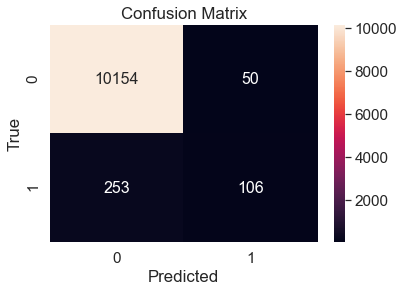

In [12]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/Initial_HistGBC_ cm.jpg', dpi=1000, bbox_inches='tight')

In [13]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8689838710910245
APRC: 0.41629864432529046
Percision: 0.6794871794871795
Recall: 0.29526462395543174
ACC: 0.9713149673388242
F1: 0.4116504854368932
F2: 0.3329145728643216
F5: 0.30182893439929903
F10: 0.2969270024406478


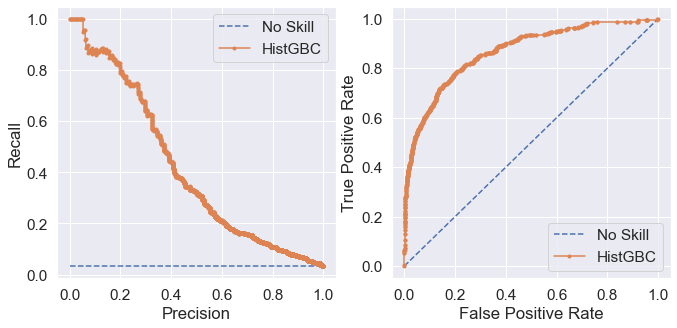

In [14]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/Initial_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [18]:
HistGradientBoostingClassifier.fit?

In [21]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc')
_, _, prob_valid, pred_valid = fit(m, xs, y, valid_xs, valid_y, sample_weight=sample_weight);

Binning 0.043 GB of training data: 0.271 s
Binning 0.005 GB of validation data: 0.018 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85586, val score: 0.84898, in 0.051s
[2/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.86816, val score: 0.85964, in 0.044s
[3/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.88226, val score: 0.86311, in 0.055s
[4/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88831, val score: 0.86550, in 0.047s
[5/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.89108, val score: 0.86803, in 0.046s
[6/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.89597, val score: 0.87163, in 0.046s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.89932, val score: 0.87652, in 0.047s
[8/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.90102, val score: 0.87697, in 0.048s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.90342, val score: 0.87688, in 0.049s
[10/1000] 1 tree,

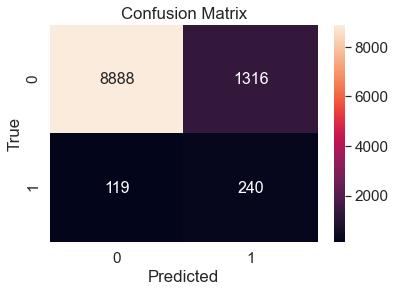

In [22]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/Initial_weighted_HistGBC_cm.jpg', dpi=1000, bbox_inches='tight')

In [23]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8712875719718849
APRC: 0.407069108331198
Percision: 0.15424164524421594
Recall: 0.6685236768802229
ACC: 0.8641484426772698
F1: 0.2506527415143603
F2: 0.40106951871657753
F5: 0.592536321337005
F10: 0.647159333618112


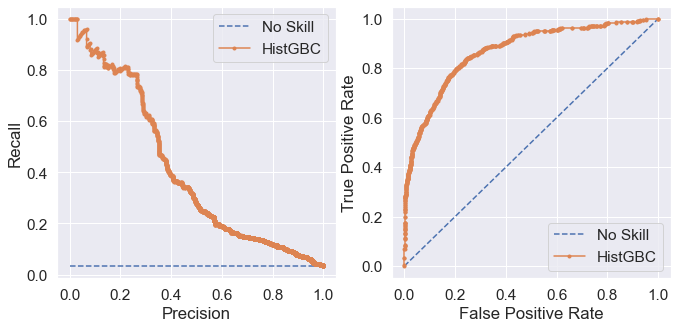

In [24]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/Initial_weighted_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [25]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, prob_valid, pred_valid = fit(m, xs, y, valid_xs, valid_y);

Binning 0.043 GB of training data: 0.265 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.84711, val score: 0.78850, in 0.056s
[2/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.85270, val score: 0.78884, in 0.053s
[3/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.86155, val score: 0.79256, in 0.053s
[4/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.86943, val score: 0.79343, in 0.051s
[5/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.87051, val score: 0.79239, in 0.052s
[6/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.87089, val score: 0.79195, in 0.052s
[7/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.87089, val score: 0.79132, in 0.053s
[8/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.88075, val score: 0.79639, in 0.053s
[9/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.88206, val score: 0.79687, in 0.053s
[10/1000] 1 tree

[85/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.94402, val score: 0.85589, in 0.073s
[86/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.94455, val score: 0.85618, in 0.078s
[87/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.94483, val score: 0.85606, in 0.070s
[88/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.94527, val score: 0.85645, in 0.122s
[89/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.94579, val score: 0.85656, in 0.070s
[90/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.94605, val score: 0.85683, in 0.069s
[91/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.94646, val score: 0.85722, in 0.070s
[92/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.94688, val score: 0.85733, in 0.071s
[93/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.94736, val score: 0.85793, in 0.075s
[94/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.94782, val score: 0.85841, in 0.073s
[95/1000] 1 tree, 44 leaves, ma

[169/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.96901, val score: 0.87192, in 0.087s
[170/1000] 1 tree, 44 leaves, max depth = 19, train score: 0.96931, val score: 0.87173, in 0.090s
[171/1000] 1 tree, 44 leaves, max depth = 19, train score: 0.96948, val score: 0.87146, in 0.085s
[172/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.96968, val score: 0.87143, in 0.085s
[173/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.96993, val score: 0.87177, in 0.086s
[174/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.97002, val score: 0.87188, in 0.146s
[175/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.97023, val score: 0.87250, in 0.085s
[176/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.97037, val score: 0.87235, in 0.083s
[177/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.97044, val score: 0.87257, in 0.084s
[178/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.97057, val score: 0.87238, in 0.083s
[179/1000] 1 tree, 4

[253/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.98218, val score: 0.88290, in 0.111s
[254/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.98230, val score: 0.88278, in 0.116s
[255/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98243, val score: 0.88286, in 0.108s
[256/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98250, val score: 0.88278, in 0.120s
[257/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.98257, val score: 0.88286, in 0.116s
[258/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.98269, val score: 0.88272, in 0.109s
[259/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.98278, val score: 0.88291, in 0.113s
[260/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.98288, val score: 0.88272, in 0.123s
[261/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.98299, val score: 0.88273, in 0.224s
[262/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98313, val score: 0.88282, in 0.110s
[263/1000] 1 tree, 4

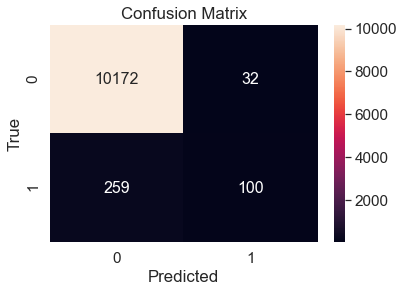

In [27]:
fig = plot_confusion_matrix(valid_y, pred_valid)
#fig.savefig(path.BASE_PATH/'../figures/RFparams_HistGBC_cm.jpg', dpi=1000, bbox_inches='tight')

In [28]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8800866228656848
APRC: 0.4456466769824395
Percision: 0.7575757575757576
Recall: 0.2785515320334262
ACC: 0.9724510082362965
F1: 0.4073319755600815
F2: 0.3188775510204082
F5: 0.2854946744262655
F10: 0.2803063943161634


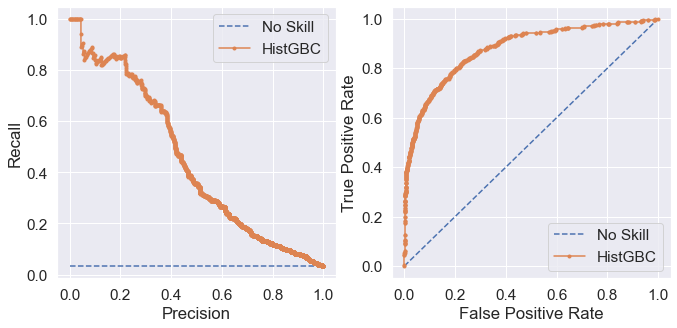

In [29]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
#fig.savefig(path.BASE_PATH/'../figures/RFparams_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [31]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, prob_valid, pred_valid = fit(m, xs, y, valid_xs, valid_y, sample_weight=sample_weight);

Binning 0.043 GB of training data: 0.290 s
Binning 0.005 GB of validation data: 0.018 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.87479, val score: 0.84558, in 0.060s
[2/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.87520, val score: 0.84699, in 0.127s
[3/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.87600, val score: 0.84781, in 0.064s
[4/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.87857, val score: 0.84782, in 0.067s
[5/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.88032, val score: 0.84532, in 0.064s
[6/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.88222, val score: 0.85322, in 0.063s
[7/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.88538, val score: 0.85738, in 0.069s
[8/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.89229, val score: 0.86345, in 0.068s
[9/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.89409, val score: 0.86416, in 0.067s
[10/1000] 1 tree, 44

[85/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.95031, val score: 0.89871, in 0.095s
[86/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.95072, val score: 0.89944, in 0.097s
[87/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.95114, val score: 0.89957, in 0.093s
[88/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.95162, val score: 0.89972, in 0.104s
[89/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.95216, val score: 0.90052, in 0.205s
[90/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.95260, val score: 0.90077, in 0.091s
[91/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.95320, val score: 0.90107, in 0.092s
[92/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.95368, val score: 0.90155, in 0.095s
[93/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.95405, val score: 0.90180, in 0.096s
[94/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.95440, val score: 0.90204, in 0.097s
[95/1000] 1 tree, 44 leaves, ma

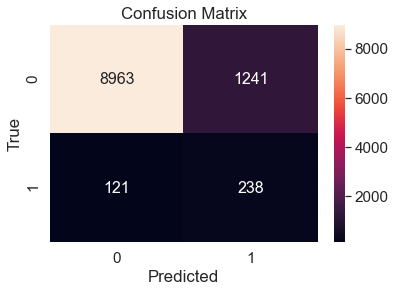

In [32]:
fig = plot_confusion_matrix(valid_y, pred_valid)
#fig.savefig(path.BASE_PATH/'../figures/RFparams_weighted_HistGBC_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')

In [33]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8736273065671992
APRC: 0.405938150085933
Percision: 0.16091954022988506
Recall: 0.6629526462395543
ACC: 0.871059358136893
F1: 0.2589771490750816
F2: 0.40823327615780447
F5: 0.5919265352974937
F10: 0.6430883651248027


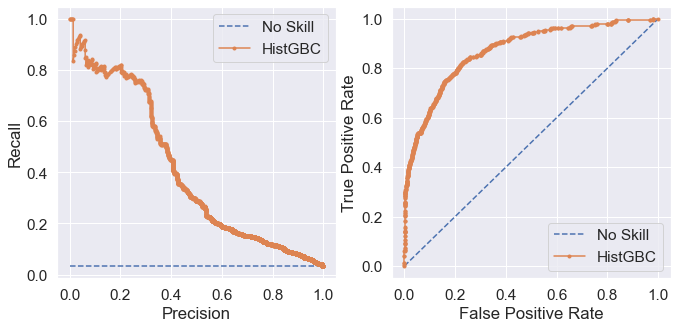

In [34]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
#fig.savefig(path.BASE_PATH/'../figures/RFparams_weighted_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

# Important features

In [36]:
xs_imp = (path/'xs_imp.pkl').load()
valid_xs_imp = (path/'valid_xs_imp.pkl').load()

In [42]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, prob_valid, pred_valid = fit(m, xs, y, valid_xs, valid_y)

Binning 0.043 GB of training data: 0.259 s
Binning 0.005 GB of validation data: 0.013 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.85905, val score: 0.79280, in 0.056s
[2/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.86074, val score: 0.79464, in 0.055s
[3/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86862, val score: 0.80143, in 0.056s
[4/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.88490, val score: 0.80983, in 0.054s
[5/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.88717, val score: 0.80886, in 0.052s
[6/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.88843, val score: 0.80863, in 0.059s
[7/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.88952, val score: 0.80805, in 0.052s
[8/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.89019, val score: 0.80795, in 0.056s
[9/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.89056, val score: 0.80745, in 0.057s
[10/1000] 1 tre

[85/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.95044, val score: 0.87235, in 0.069s
[86/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.95107, val score: 0.87260, in 0.069s
[87/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.95156, val score: 0.87275, in 0.067s
[88/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.95198, val score: 0.87349, in 0.125s
[89/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.95259, val score: 0.87390, in 0.066s
[90/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.95299, val score: 0.87376, in 0.066s
[91/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.95350, val score: 0.87429, in 0.066s
[92/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.95382, val score: 0.87433, in 0.066s
[93/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.95442, val score: 0.87453, in 0.069s
[94/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.95494, val score: 0.87435, in 0.068s
[95/1000] 1 tree, 44 leaves, m

[169/1000] 1 tree, 44 leaves, max depth = 18, train score: 0.97498, val score: 0.88981, in 0.098s
[170/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.97519, val score: 0.88978, in 0.095s
[171/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.97560, val score: 0.88983, in 0.095s
[172/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.97575, val score: 0.89004, in 0.096s
[173/1000] 1 tree, 44 leaves, max depth = 20, train score: 0.97589, val score: 0.89030, in 0.097s
[174/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.97607, val score: 0.89039, in 0.099s
[175/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.97616, val score: 0.89076, in 0.153s
[176/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.97633, val score: 0.89077, in 0.099s
[177/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.97647, val score: 0.89104, in 0.103s
[178/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.97669, val score: 0.89109, in 0.098s
[179/1000] 1 tree, 4

[253/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.98552, val score: 0.89690, in 0.134s
[254/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.98560, val score: 0.89697, in 0.141s
[255/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98572, val score: 0.89709, in 0.137s
[256/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98579, val score: 0.89711, in 0.118s
[257/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.98586, val score: 0.89730, in 0.116s
[258/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98599, val score: 0.89757, in 0.144s
[259/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.98609, val score: 0.89765, in 0.128s
[260/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.98614, val score: 0.89775, in 0.130s
[261/1000] 1 tree, 44 leaves, max depth = 18, train score: 0.98617, val score: 0.89786, in 0.141s
[262/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.98624, val score: 0.89793, in 0.213s
[263/1000] 1 tree, 4

[337/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.99086, val score: 0.90102, in 0.228s
[338/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.99093, val score: 0.90090, in 0.151s
[339/1000] 1 tree, 44 leaves, max depth = 8, train score: 0.99095, val score: 0.90098, in 0.152s
[340/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.99098, val score: 0.90116, in 0.154s
[341/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.99105, val score: 0.90116, in 0.177s
[342/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.99110, val score: 0.90111, in 0.168s
[343/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.99113, val score: 0.90116, in 0.178s
[344/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.99117, val score: 0.90123, in 0.155s
Fit 344 trees in 38.260 s, (15136 total leaves)
Time spent computing histograms: 11.674s
Time spent finding best splits:  2.839s
Time spent applying splits:      4.020s
Time spent predicting:           0.054s
Train_AR

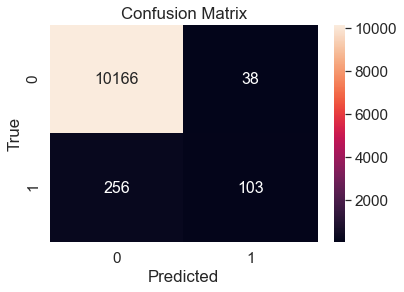

In [43]:
fig = plot_confusion_matrix(valid_y, pred_valid)

In [44]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8822183446548353
APRC: 0.44913791613297194
Percision: 0.7304964539007093
Recall: 0.28690807799442897
ACC: 0.9721669980119284
F1: 0.4120000000000001
F2: 0.326569435637286
F5: 0.2937691970162352
F10: 0.28864348935934075


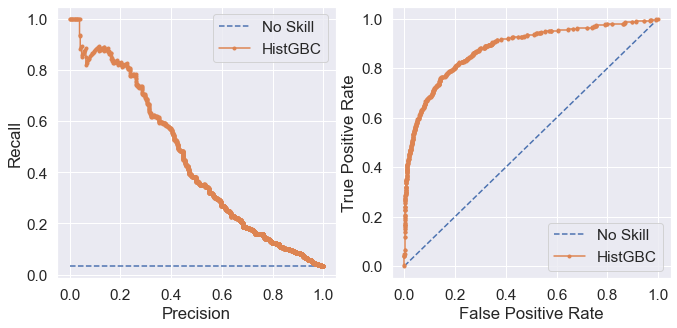

In [45]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')

# Hyperparameter tuning

Hyperparameters were tuned interatively using GridSearchCV. 

In [46]:
xs_imp.shape, y.shape, valid_xs_imp.shape, valid_y.shape

((48491, 61), (48491,), (10563, 61), (10563,))

In [77]:
HistGradientBoostingClassifier?

In [75]:
parameters1 = {
 'max_depth': [15],
 'random_state': [33],
 }

In [93]:
parameters2 = {
 'max_depth': [15],
 'learning_rate': [0.1],
 'random_state': [33],
 }

In [132]:
parameters3 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'random_state': [33],
 }

In [149]:
parameters4 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'random_state': [33],
 }

In [159]:
parameters5 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'max_leaf_nodes': [31],
 'random_state': [33],
 }

In [175]:
parameters6 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'max_leaf_nodes': [31],
 'tol': [1e-8]
 'random_state': [33],
 }

In [176]:
clf = GridSearchCV(HistGradientBoostingClassifier(loss='binary_crossentropy', max_iter=1000, 
                                                  scoring='roc_auc', tol=1e-8), parameters6, 
                   scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1, cv=3,
                   verbose=3)

In [177]:
%%time
clf.fit(xs, y)
clf.best_estimator_, clf.best_score_, clf.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  2.6min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  4.7min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.9min finished


CPU times: user 3min 45s, sys: 1min 27s, total: 5min 13s
Wall time: 6min 48s


(HistGradientBoostingClassifier(l2_regularization=4.0,
                                loss='binary_crossentropy', max_depth=15,
                                max_iter=1000, random_state=33,
                                scoring='roc_auc', tol=1e-08),
 0.8963061409318414,
 {'l2_regularization': 4.0,
  'learning_rate': 0.1,
  'max_depth': 15,
  'max_leaf_nodes': 31,
  'min_samples_leaf': 20,
  'random_state': 33,
  'tol': 1e-08})

In [48]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0)
_, _, prob_valid, pred_valid = fit(m, xs, y, valid_xs, valid_y)

Binning 0.043 GB of training data: 0.261 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.81461, val score: 0.83414, in 0.046s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.83575, val score: 0.84127, in 0.045s
[3/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.84108, val score: 0.84249, in 0.045s
[4/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.85816, val score: 0.86642, in 0.078s
[5/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.86625, val score: 0.86929, in 0.061s
[6/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87173, val score: 0.87229, in 0.051s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.87538, val score: 0.87100, in 0.051s
[8/1000] 1 tree, 31 leaves, max depth = 7, train score: 0.87831, val score: 0.87221, in 0.049s
[9/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.88105, val score: 0.87166, in 0.049s
[10/1000] 1 tree, 31 l

[85/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.95995, val score: 0.89047, in 0.091s
[86/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96045, val score: 0.88995, in 0.077s
[87/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96077, val score: 0.89032, in 0.068s
[88/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.96102, val score: 0.89066, in 0.068s
[89/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96147, val score: 0.89119, in 0.071s
[90/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.96189, val score: 0.89124, in 0.067s
[91/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.96262, val score: 0.89112, in 0.069s
[92/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.96278, val score: 0.89129, in 0.072s
[93/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96329, val score: 0.89157, in 0.076s
[94/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.96347, val score: 0.89191, in 0.081s
[95/1000] 1 tree, 31 leaves, ma

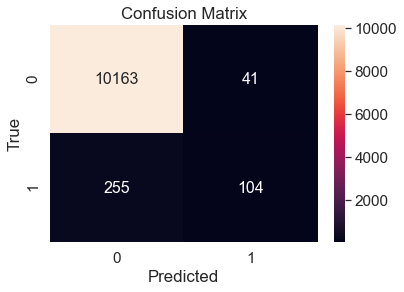

In [49]:
fig = plot_confusion_matrix(valid_y, pred_valid)

In [50]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8822164337760383
APRC: 0.4430083455930451
Percision: 0.7172413793103448
Recall: 0.28969359331476324
ACC: 0.9719776578623497
F1: 0.41269841269841273
F2: 0.3289057558507274
F5: 0.2964912280701754
F10: 0.2914135108891664


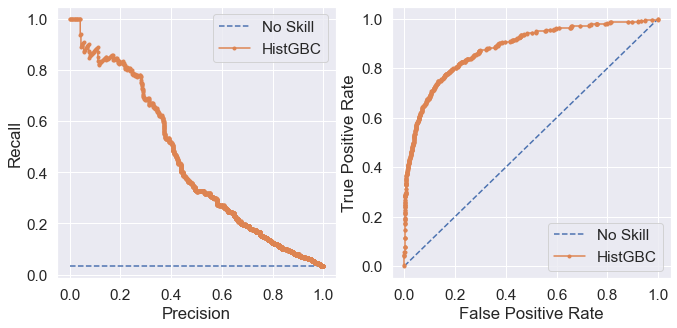

In [51]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')

In [53]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0)
_, _, prob_valid, pred_valid = fit(m, xs, y, valid_xs, valid_y, sample_weight=sample_weight)

Binning 0.043 GB of training data: 0.285 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.87422, val score: 0.83129, in 0.049s
[2/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88337, val score: 0.85245, in 0.048s
[3/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.88954, val score: 0.85954, in 0.048s
[4/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.89054, val score: 0.86531, in 0.048s
[5/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.89649, val score: 0.86784, in 0.054s
[6/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.89905, val score: 0.86896, in 0.052s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.89933, val score: 0.87057, in 0.052s
[8/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.90282, val score: 0.86928, in 0.053s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.90435, val score: 0.86808, in 0.054s
[10/1000] 1 tree, 31 

[85/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.97924, val score: 0.90434, in 0.076s
[86/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.97969, val score: 0.90451, in 0.078s
[87/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.98018, val score: 0.90447, in 0.075s
[88/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.98058, val score: 0.90483, in 0.073s
[89/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.98107, val score: 0.90463, in 0.072s
[90/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.98126, val score: 0.90471, in 0.075s
[91/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.98158, val score: 0.90443, in 0.074s
[92/1000] 1 tree, 31 leaves, max depth = 15, train score: 0.98187, val score: 0.90518, in 0.075s
[93/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.98211, val score: 0.90554, in 0.073s
[94/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98236, val score: 0.90557, in 0.073s
[95/1000] 1 tree, 31 leaves, max

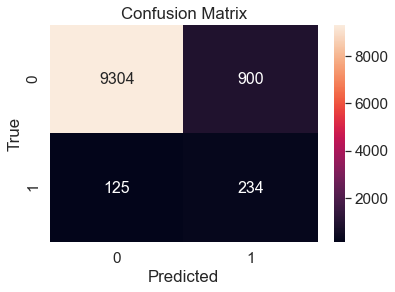

In [54]:
fig = plot_confusion_matrix(valid_y, pred_valid)

In [55]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8812547157758877
APRC: 0.4184872854435166
Percision: 0.20634920634920634
Recall: 0.6518105849582173
ACC: 0.9029631733409069
F1: 0.3134628265237776
F2: 0.4552529182879377
F5: 0.6018399446038184
F10: 0.6381703299670575


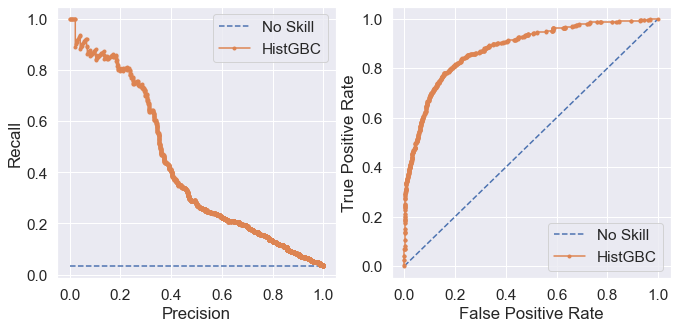

In [56]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')